In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels import api as sm
import matplotlib.pyplot as plt

План: 

1. Выявление тенденций и закономерностей в движении фондовых рынков основных регионов мира
2. Детальный анализ долгосрочной динамики развития индексов Европы, Азии, Китая, Индии, США
3. Отбор пула факторов, специфичных для приоритетного воздействия на финансовый рынок каждого региона
4. Количественная оценка методом регрессионного анализа влияния данных факторов на динамика индексов
5. Экономическая интерпретация полученных результатов


# Загрузка данных и описательная статистика

| Название страны      | Название индекса | Тикер      |
|----------------------|-------------------|------------|
| США                  | S&P 500           | SPX Index  |
| Европейский союз     | EURO STOXX        | SX5E Index |
| Великобритания       | FTSE 100          | UKX Index  |
| Германия             | DAX               | DAX Index  |
| Франция              | CAC 40            | CAC Index  |
| Япония               | NIKKEI            | NKY Index  |
| Китай (Гонконг)      | HANG SENG         | HSI Index  |
| Австралия            | ASX 200           | AS51 Index |
| Индия                | NIFTY             | NIFTY Index|

In [3]:
df = pd.read_excel('data.xlsx', sheet_name='static')
df = df.set_index("Dates")

### Наличие данных по каждому индексу:

In [4]:
print("Starting time by index:")
print("")
last_idx = df.index[-1]
for col in df.columns:
    print(f"{col}: {df[col].first_valid_index():%d-%b-%Y} to {last_idx:%d-%b-%Y}")

Starting time by index:

SPX Index: 23-Jan-1985 to 23-Jan-2025
SX5E Index: 31-Dec-1986 to 23-Jan-2025
UKX Index: 23-Jan-1985 to 23-Jan-2025
DAX Index: 23-Jan-1985 to 23-Jan-2025
CAC Index: 09-Jul-1987 to 23-Jan-2025
NKY Index: 23-Jan-1985 to 23-Jan-2025
HSI Index: 23-Jan-1985 to 23-Jan-2025
AS51 Index: 29-May-1992 to 23-Jan-2025
NIFTY Index: 03-Jul-1990 to 23-Jan-2025


In [5]:
df.describe()

,SPX Index,SX5E Index,UKX Index,DAX Index,CAC Index,NKY Index,HSI Index,AS51 Index,NIFTY Index
count,10079.000000,9809.000000,10123.000000,10109.000000,9529.000000,9827.000000,9876.000000,8268.000000,8352.000000
mean,1521.676880,2776.403735,5005.501395,6508.465467,4015.794064,18684.288694,15013.186374,4496.924599,5892.929474
std,1272.562597,1195.437731,1944.278784,4698.702530,1693.425084,7319.177238,8295.238449,1756.366283,5953.261343
min,176.530000,615.900000,1221.700000,820.300000,893.820000,7054.980000,1300.970000,1358.500000,279.020000
25%,474.150000,1627.220000,3221.550000,2151.720000,2442.460000,12972.640000,9009.910000,3028.945500,1123.800000
50%,1193.860000,2941.760000,5478.810000,5520.710000,4031.990000,17572.680000,15034.210000,4582.851000,4197.075000
75%,1989.415000,3604.820000,6551.105000,9772.670000,5217.590000,22498.840000,22091.750000,5811.360000,8565.137500
max,6090.270000,5464.430000,8559.560000,21318.520000,8239.990000,42224.020000,33154.120000,8495.217000,26216.050000


### Годовая доходность по каждому индексу за последние 10 лет

In [7]:
df.resample("YE").last().pct_change().multiply(100).round(2).tail(10)

,SPX Index,SX5E Index,UKX Index,DAX Index,CAC Index,NKY Index,HSI Index,AS51 Index,NIFTY Index
Dates,,,,,,,,,
2016-12-31,9.54,0.70,14.43,6.87,4.86,0.42,0.39,6.99,3.01
2017-12-31,19.42,6.49,7.63,12.51,9.26,19.10,35.99,7.05,28.65
2018-12-31,-6.24,-14.34,-12.48,-18.26,-10.95,-12.08,-13.61,-6.90,3.15
2019-12-31,28.88,24.78,12.10,25.48,26.37,18.20,9.07,18.38,12.02
2020-12-31,16.26,-5.14,-14.34,3.55,-7.14,16.01,-3.40,-1.45,14.90
2021-12-31,26.89,20.99,14.30,15.79,28.85,4.91,-14.08,13.02,24.12
2022-12-31,-19.44,-11.74,0.91,-12.35,-9.50,-9.37,-15.46,-5.45,4.33
2023-12-31,24.23,19.19,3.78,20.31,16.52,28.24,-13.82,7.84,20.03
2024-12-31,23.31,8.28,5.69,18.85,-2.15,19.22,17.67,7.49,8.80


### Кумулятивный рост (Июнь-92 — Январь-25)

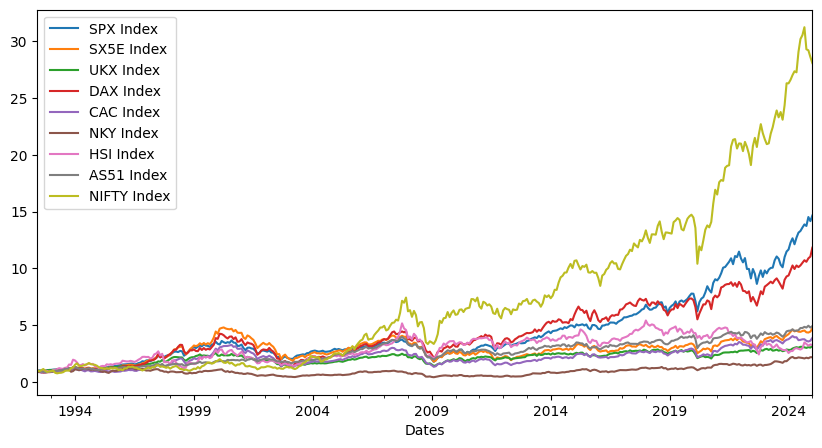

In [8]:
df.resample("ME").last().pct_change().dropna().add(1).cumprod().plot(figsize=(10, 5));

### Описательная статистика ежедневной доходности

In [9]:
df.resample("YE").last().pct_change(fill_method=None).describe()

,SPX Index,SX5E Index,UKX Index,DAX Index,CAC Index,NKY Index,HSI Index,AS51 Index,NIFTY Index
count,40.000000,39.000000,40.000000,40.000000,38.000000,40.000000,40.000000,33.000000,35.000000
mean,0.101081,0.067965,0.055882,0.096426,0.077742,0.053806,0.100281,0.062744,0.166527
std,0.164044,0.207907,0.140346,0.223467,0.212770,0.229169,0.304278,0.142638,0.291234
min,-0.384858,-0.443687,-0.313266,-0.439424,-0.426804,-0.421238,-0.482700,-0.412870,-0.517944
25%,0.015200,-0.054730,-0.032663,-0.033309,-0.030448,-0.098097,-0.116570,-0.014509,0.009877
50%,0.125918,0.068951,0.075828,0.126841,0.079628,0.059135,0.049293,0.074870,0.133984
75%,0.236483,0.210642,0.144623,0.254778,0.222658,0.191278,0.295897,0.147225,0.338348
max,0.341107,0.467382,0.351124,0.471148,0.573940,0.567198,1.156667,0.350802,0.757616


### Корреляционная матрица

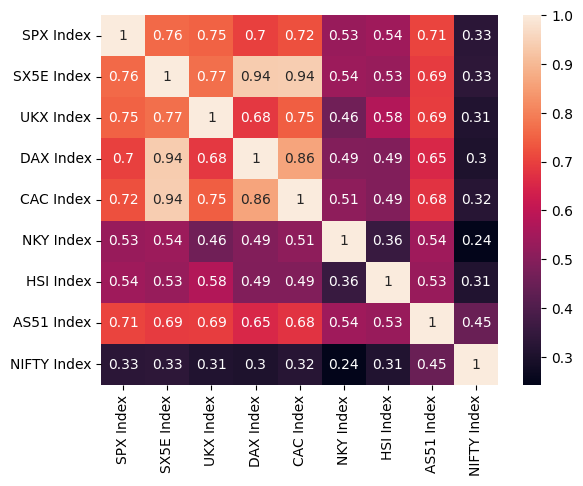

In [8]:
corr = df.resample("M").last().pct_change().corr()
sns.heatmap(corr, annot=True);

## Анализ долгосрочной динамики

In [9]:
def describe_index(index_prices: pd.Series):
    daily_returns = index_prices.dropna().pct_change()
    daily_mean = daily_returns.mean()
    daily_vol = daily_returns.std()
    ann_mean = daily_mean * 252
    ann_vol = daily_vol * (252 **0.5)
    sharpe = ann_mean / ann_vol    

    cumulative_returns = (1 + daily_returns).cumprod()
    running_max = cumulative_returns.cummax()    
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    info = {
        "Среднегодовая доходность": ann_mean, 
        "Среднегодовая волатильность": ann_vol, 
        "Коэффициент Шарпа": sharpe,
        "Макс. просадка": max_drawdown
    }
    return info

In [10]:
returns_overview = pd.DataFrame([describe_index(df[col]) for col in df.columns], index=df.columns)
returns_overview.style.format({
    'Среднегодовая доходность': '{:.2%}',
    'Среднегодовая волатильность': '{:.2%}',
    'Макс. просадка': '{:.2%}',
    'Коэффициент Шарпа': '{:.2f}'
})

,Среднегодовая доходность,Среднегодовая волатильность,Коэффициент Шарпа,Макс. просадка
SPX Index,10.50%,18.16%,0.58,-56.78%
SX5E Index,6.61%,20.50%,0.32,-66.88%
UKX Index,6.20%,17.13%,0.36,-52.57%
DAX Index,10.47%,21.87%,0.48,-72.68%
CAC Index,6.70%,21.35%,0.31,-65.29%
NKY Index,5.69%,22.65%,0.25,-81.87%
HSI Index,10.10%,25.38%,0.40,-65.18%
AS51 Index,6.02%,15.23%,0.40,-53.94%
NIFTY Index,16.39%,24.68%,0.66,-59.86%


### Потенциальные макроэкономические факторы
1. Процентные ставки и денежно-кредитная политика
- Ставка центральных банков
- Кривые доходности (10Y-2Y):
- Реальные процентные ставки.
2. Инфляция ???

3. Экономический рост
- ВВП
- PMI (индекс экономической активности) (пояснить запазд или опереж)
- индекс по недвижимости
- макроиндексы
- Промышленное производство:
4. Данные о занятости
Безработица
Рост заработной платы
5. Фискальная политика
- Государственные расходы и дефицит:
6. Курсы валют
7. Цены на сырьевые товары
- Нефть и металлы:
- Медь
8. Глобальная торговля и потоки капитала
- Торговые балансы
- Иностранные инвестиции

In [25]:
data = pd.read_excel('datamfs.xlsx', sheet_name='US')
data = data.set_index("Dates")
data.index = pd.to_datetime(data.index)

print(data.head())

selected_columns = ['GT10 Govt', 'GT2 Govt', 'FDTR Index', 'GT5 Govt', 'GTII05 Govt', 'CPI YOY  Index', 'CPI XYOY Index', 'IP Index',
                    'GDP CQOQ Index', 'USURTOT Index', 'REALAHRE Index', 'FDDSGDP Index', 'USTBTOT  Index', 'GDPUNSA  Index']
data = data[selected_columns]

if data.isnull().sum().any():
    print("Missing values detected. Impute or drop them.")
    data = data.dropna()

            GT10 Govt  GT2 Govt  FDTR Index  GT5 Govt  GTII05 Govt  \
Dates                                                                
1985-01-29     11.001     9.706        8.25    10.601          NaN   
1985-01-30     11.089     9.794        8.25    10.681          NaN   
1985-01-31     11.173     9.917        8.25    10.795          NaN   
1985-02-01     11.320    10.005        8.25    10.942          NaN   
1985-02-04     11.309     9.987        8.25    10.933          NaN   

            CPI YOY  Index  CPI XYOY Index  IP Index  GDP CQOQ Index  \
Dates                                                                  
1985-01-29             3.9             4.7   54.5556             3.3   
1985-01-30             3.9             4.7   54.5556             3.3   
1985-01-31             3.5             4.5   54.5270             3.3   
1985-02-01             3.5             4.5   54.5270             3.3   
1985-02-04             3.5             4.5   54.5270             3.3   

    

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [13]:
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(selected_columns))])
print(pc_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.076607 -3.109978 -0.507647  0.845903  0.867056 -0.527412 -0.531953   
1  3.095531 -3.124337 -0.516245  0.841451  0.871567 -0.523690 -0.530417   
2  3.089722 -3.123853 -0.514722  0.841121  0.870620 -0.520580 -0.533944   
3  3.061941 -3.099197 -0.501624  0.850596  0.863960 -0.531213 -0.530189   
4  3.101565 -3.132494 -0.522857  0.847348  0.875390 -0.525085 -0.514549   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  
0  0.080402 -0.300218  0.218943 -0.263887  0.040037  0.175097  0.030682  
1  0.073756 -0.302822  0.218785 -0.265000  0.048104  0.180950  0.027860  
2  0.069871 -0.298911  0.217747 -0.250251  0.046254  0.168694  0.025261  
3  0.084815 -0.298459  0.217796 -0.265144  0.030902  0.169477  0.024647  
4  0.058985 -0.305853  0.207554 -0.278090  0.038032  0.167684  0.019281  


Eigenvalues: [6.38440243e+00 3.24518086e+00 1.49244323e+00 1.01365179e+00
 9.59658000e-01 3.08902917e-01 1.72561981e-01 1.22136099e-01
 1.12292263e-01 8.84973003e-02 4.98998147e-02 3.84819362e-02
 1.30040623e-02 1.73690120e-03]


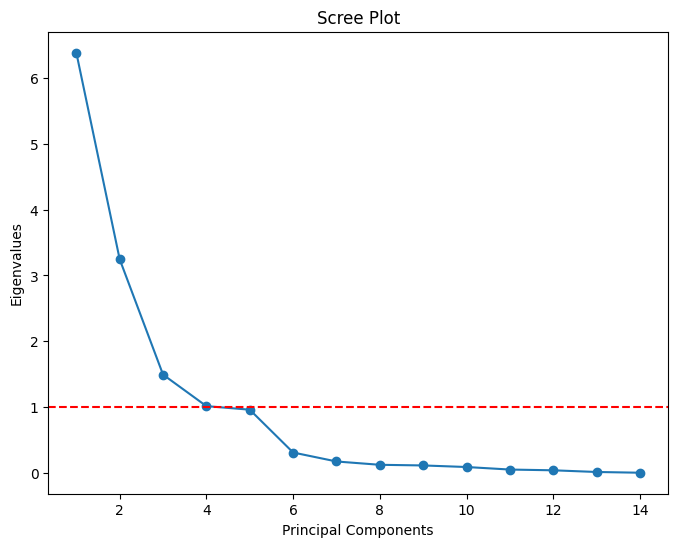

In [14]:
# Eigenvalues
explained_variance = pca.explained_variance_
print("Eigenvalues:", explained_variance)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--')  # Threshold for retaining factors
plt.show()

Cumulative Variance Explained: [0.45593594 0.6876874  0.7942688  0.86665776 0.93519081 0.95725082
 0.96957417 0.9782964  0.98631564 0.99263559 0.99619914 0.99894729
 0.99987596 1.        ]


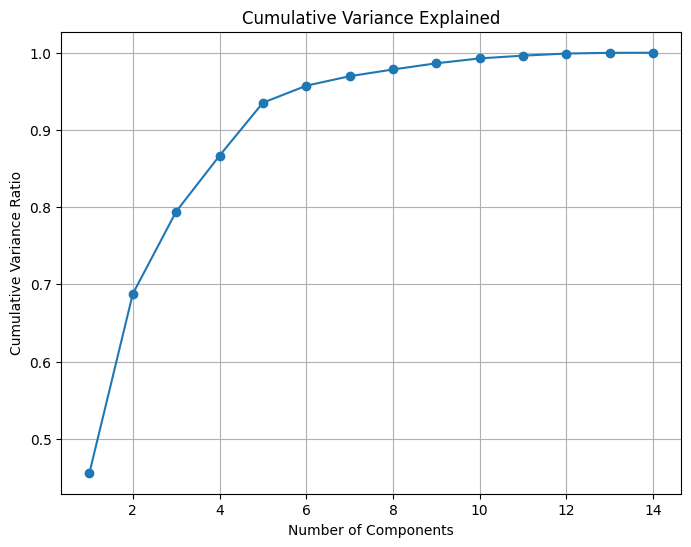

In [15]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Variance Explained:", cumulative_variance)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid()
plt.show()

In [16]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(selected_columns))], index=selected_columns)
print("Factor Loadings:")
print(loadings)

# Highlight the most important variables for each PC
for pc in loadings.columns:
    print(f"\nTop contributors to {pc}:")
    print(loadings[pc].nlargest(3))  # Show top 3 contributors

Factor Loadings:
                     PC1       PC2       PC3       PC4       PC5       PC6  \
GT10 Govt       0.277663 -0.330670 -0.227660  0.084208  0.126066  0.030328   
GT2 Govt        0.373655 -0.129144 -0.104399 -0.110299  0.055747 -0.050478   
FDTR Index      0.357864 -0.122811 -0.086126 -0.170681  0.103696 -0.285349   
GT5 Govt        0.348339 -0.227563 -0.149229 -0.029607  0.081586  0.032723   
GTII05 Govt     0.292327 -0.310226 -0.117680 -0.230853  0.051582  0.244952   
CPI YOY  Index  0.238179  0.231072 -0.106386  0.594945 -0.212742  0.073615   
CPI XYOY Index  0.282177  0.276359 -0.096922  0.239395 -0.202254  0.541980   
IP Index        0.252678  0.148026  0.530336  0.014687 -0.081342 -0.414290   
GDP CQOQ Index  0.040901  0.119994  0.238551  0.278484  0.894636  0.167052   
USURTOT Index  -0.302978 -0.106467 -0.443225  0.090538  0.046755 -0.027796   
REALAHRE Index  0.080563  0.457620 -0.085434 -0.479846  0.053913  0.073225   
FDDSGDP Index   0.142387 -0.322633  0.521101  0

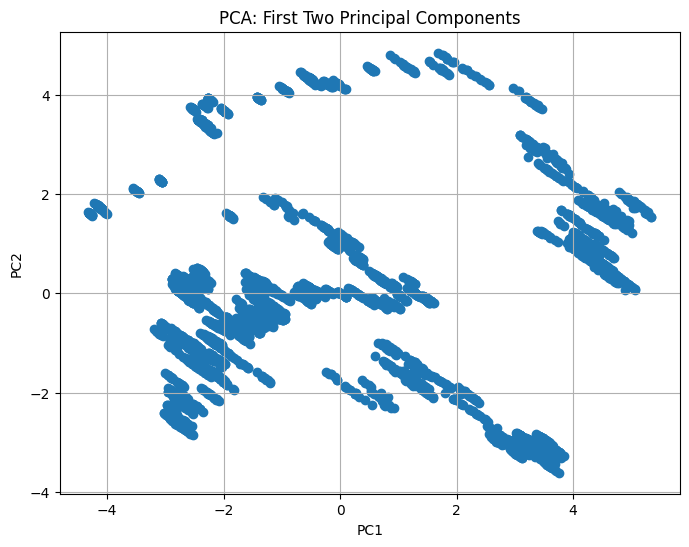

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

$Y=a + BX$

In [40]:
# df['SPX Index']

'2.1.4'

In [125]:
monthly = data.resample("M").last()
# Spread between 2Yr and 10Yr rates
curve = (monthly['GT10 Govt'] - monthly['GT2 Govt']).rename("yield_curve_diff")
# Spread between normal and inflation protected 5yr bonds (means inflation expectation)
inf_exp = (monthly['GT5 Govt'] - monthly['GTII05 Govt']).rename("inf_exp")
# Ставка ЦБ
policy_rate = monthly['FDTR Index'].rename("policy_rate")
# Изменение ставки ЦБ
policy_rate_chg = policy_rate.diff().rename("policy_rate_chg")
# Инфляция (headline)
headline_inf = monthly['CPI YOY  Index'].rename("headline_inf")
# Инфляция (core)
core_inf = monthly['CPI XYOY Index'].rename("core_inf")
# Индекс индустриального производства
ip_idx_change = monthly['IP Index'].pct_change().multiply(100).rename("ip_index_chg")
# Уровень безработицы
unemployment_rate = monthly['USURTOT Index'].rename("u_rate")
# Изменение уровня безработицы
u_rate_chg = unemployment_rate.diff().rename("u_rate_chg")
# Изменение в реальной почасовой оплате
hourly_earnings_chg = monthly['REALAHRE Index'].pct_change().multiply(100).rename("rahe_chg")
# Дефицит бюджета
budget_deficit = monthly['FDDSGDP Index'].rename("budget_def")
# Изменение в дефиците бюджета
budget_deficit_chg = budget_deficit.diff().rename("budget_def_chg")
# Торговый баланс (как % от ВВП)
trade_deficit = (monthly['USTBTOT  Index'] / monthly['GDPUNSA  Index']).multiply(100).rename("trade_deficit")
# Изменение торгового баланса
trade_deficit_chg = trade_deficit.diff().rename("trade_deficit_chg")

In [126]:
factors_df = pd.concat([
    curve, inf_exp, policy_rate, policy_rate_chg, headline_inf, core_inf, ip_idx_change, unemployment_rate, 
    u_rate_chg, hourly_earnings_chg, budget_deficit, budget_deficit_chg,
    trade_deficit, trade_deficit_chg
], axis=1).iloc[1:]
dep_var = df['SPX Index'].resample("M").last().pct_change().iloc[1:].multiply(100)

common_idx = factors_df.index.intersection(dep_var.index)
factors_df = factors_df.loc[common_idx]
dep_var = dep_var.loc[common_idx]

In [129]:
model = sm.OLS(
    dep_var,
    sm.add_constant(factors_df)
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SPX Index   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     5.014
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           4.67e-08
Time:                        13:26:20   Log-Likelihood:                -624.39
No. Observations:                 226   AIC:                             1279.
Df Residuals:                     211   BIC:                             1330.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.2456      2.163     -2.425      0.016      -9.510      -0.982
yield_curve_diff     -1.1487      0.639     -1.799      0.073      -2.407       0.110
inf_exp               4.0701      0.759      5.361      0.000       2.574       5.567
policy_rate          -0.0666      0.263     -0.254      0.800      -0.584       0.451
policy_rate_chg       1.9969      1.419      1.408      0.161      -0.800       4.794
headline_inf         -1.0542      0.313     -3.365      0.001      -1.672      -0.437
core_inf              0.2240      0.482      0.465      0.642      -0.725       1.173
ip_index_chg          0.2578      0.393      0.656      0.512      -0.516       1.032
u_rate                0.5165      0.270      1.915      0.057      -0.015       1.048
u_rate_chg            0.0933      0.743      0.126      0.900      -1.371       1.557
rahe_chg              1.5989      0.794      2.013      0.045       0.033       3.164
budget_def           -0.0380      0.117     -0.324      0.746      -0.269       0.193
budget_def_chg       -0.2140      0.415     -0.516      0.607      -1.032       0.604
trade_deficit         1.6535      1.345      1.230      0.220      -0.997       4.304
trade_deficit_chg    -0.6560      3.349     -0.196      0.845      -7.257       5.945
==============================================================================
Omnibus:                        0.168   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.920   Jarque-Bera (JB):                0.049
Skew:                          -0.028   Prob(JB):                        0.976
Kurtosis:                       3.045   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
final_model = sm.OLS(dep_var, sm.add_constant(factors_df)).fit_regularized(
    alpha=0.1,
    L1_wt=1,
    cnvrg_tol=1e-6,
    maxiter=10_000
)
lasso_params = final_model.params
lasso_params

const                0.000000
yield_curve_diff    -0.665259
inf_exp              2.026802
policy_rate          0.000000
policy_rate_chg      0.463404
headline_inf        -0.853100
core_inf             0.000000
ip_index_chg         0.057063
u_rate               0.000000
u_rate_chg           0.574827
rahe_chg             0.000000
budget_def          -0.183160
budget_def_chg       0.000000
trade_deficit        1.133280
trade_deficit_chg    0.000000
dtype: float64

In [158]:
filtered_factors = lasso_params[lasso_params!=0].index

In [161]:
model = sm.OLS(
    dep_var,
    sm.add_constant(factors_df[filtered_factors])
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SPX Index   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     7.674
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           4.85e-09
Time:                        13:49:02   Log-Likelihood:                -628.70
No. Observations:                 226   AIC:                             1275.
Df Residuals:                     217   BIC:                             1306.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.3044      1.516     -1.520      0.130      -5.293       0.684
yield_curve_diff    -0.6225      0.310     -2.009      0.046      -1.233      -0.012
inf_exp              3.3276      0.675      4.928      0.000       1.997       4.659
policy_rate_chg      2.1563      1.342      1.606      0.110      -0.489       4.802
headline_inf        -1.0850      0.196     -5.526      0.000      -1.472      -0.698
ip_index_chg         0.2463      0.362      0.680      0.497      -0.468       0.961
u_rate_chg           1.1699      0.603      1.941      0.054      -0.018       2.358
budget_def          -0.2108      0.082     -2.576      0.011      -0.372      -0.050
trade_deficit        1.0787      1.078      1.000      0.318      -1.047       3.204
==============================================================================
Omnibus:                        0.472   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.227
Skew:                          -0.024   Prob(JB):                        0.893
Kurtosis:                       3.148   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""